In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [2]:
df_hard = pd.read_csv('sf_hard.csv')
df_hard.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,The Martian,The Martian,Andy Weir,English,4.40,846623,73943,"Six days ago, astronaut Mark Watney became one...",2012,"{'Science Fiction': 12536, 'Fiction': 8948, 'A...",https://www.goodreads.com/book/show/18007564-t...
1,The Three-Body Problem,三体,Liu Cixin,English,4.06,161942,16092,The Three-Body Problem is the first chance for...,2006,"{'Science Fiction': 5069, 'Fiction': 2958, 'Cu...",https://www.goodreads.com/book/show/20518872-t...
2,Red Mars,Red Mars,Kim Stanley Robinson,English,3.86,69044,3436,"In his most ambitious project to date, award-w...",1992,"{'Science Fiction': 2848, 'Fiction': 1072, 'Sc...",https://www.goodreads.com/book/show/77507.Red_...
3,Rendezvous with Rama,Rendezvous with Rama,Arthur C. Clarke,English,4.10,137065,4159,"At first, only a few things are known about th...",1973,"{'Science Fiction': 4066, 'Fiction': 1200, 'Cl...",https://www.goodreads.com/book/show/112537.Ren...
4,Revelation Space,Revelation Space,Alastair Reynolds,English,3.98,45732,2197,"Nine hundred thousand years ago, something ann...",2000,"{'Science Fiction': 2073, 'Fiction': 499, 'Spa...",https://www.goodreads.com/book/show/89187.Reve...


In [3]:
import re

# removes all punctuation
# https://stackoverflow.com/questions/1276764/stripping-everything-but-alphanumeric-chars-from-a-string-in-python
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z ]+', '', text)

# define words to count here

female_words = ['she', 'her', 'female', 'woman', 'girl']
male_words = ['he', 'his', 'male', 'man', 'boy']
words_of_interest = female_words + male_words

def text_analysis(df):
    # Create dictionary to keep counts of all rows per decade
    counts_per_decade =  dict()
    
    # go row by row
    # https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
    for index, row in df.iterrows():
        
        # 'row[column]' specifies the cell you are working with, like excel. 
        year = int(row['Year_published'])
        if year == 0: # filtering out missing years 
            continue
        
        # Get book description cell as lower case string
        book_description = str(row['Book_Description']).lower()
        book_description = remove_punctuation(book_description) # calling the function to clean the text
        
        # Seperate description into a list of strings. split() always returns a list 
        words_in_book_description = book_description.split(' ')
        
        # Create a dictionary for counts of this row
        counts = {
            'number_of_books': 1, # number_of_books is always 1, count 1 per row
        }
        
        # For each word defined in words_of_interest, create a key in counts with value 0
        for word in words_of_interest:
            counts[word] = 0
        
        # For each word in book description that matches a word of interest, add 1 to its count in dictionary
        for word in words_in_book_description:
            if word in words_of_interest: 
                counts[word] += 1
        
        # Calculate decade by dividing by 10 and rounding down 
        # https://stackoverflow.com/questions/31481589/separating-list-of-years-into-decades
        decade = int(year/10) * 10
        
        # If counts_per_decade for this decade already had counts, add those old counts to new counts
        # counts_per_decade {1980: {he: 1, she: 2}}
        if decade in counts_per_decade:
            # for each old count, add it to counts
            for key, old_count in counts_per_decade[decade].items():
                counts[key] += old_count
        
        # At this point we have the latest counts for this decade
        # Set the new counts for this decade and continue with next row
        counts_per_decade[decade] = counts

    # At this point we are done with all books and have all the counts for all decades
    
    # Pandas needs the data in a specific format
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
    pandas_dict = {
        'decade': [], # each key will be a column in DataFrame
        '# books': [],
    }
    # Create one column per word in words_of_interest
    for word in words_of_interest:
        pandas_dict[word] = []
    
    # For each decade, enter counts to the pandas_dict. Each decade will be a row in DataFrame
    for decade, counts in sorted(counts_per_decade.items()): #sorted() sorts in ascending ordee the decades 
        pandas_dict['decade'].append(decade)
        pandas_dict['# books'].append(counts['number_of_books'])
        for word in words_of_interest:
            pandas_dict[word].append(counts[word])
    
    # At this point we have the full pandas_dict
    # Convert it to DataFrame https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
    data_frame = pd.DataFrame.from_dict(pandas_dict)
    
    # Calculate more columns from existing columns using lambdas
    # https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
    def total_words(row, list_of_words):
        total_count = 0
        for word in list_of_words:
            total_count += row[word]
        return total_count
            
            
    def average_words_per_book(row, list_of_words):
        num_books = row['# books']
        total_count = total_words(row, list_of_words)
        return total_count / num_books
        
    # Lambda notation basically means this: data_frame.for_each_row(apply: average_words_per_book(row, words))
    data_frame['total_female_words'] = data_frame.apply (lambda row: total_words(row, female_words), axis=1)
    data_frame['total_male_words'] = data_frame.apply (lambda row: total_words(row, male_words), axis=1)
    
    data_frame['avg_f_wpb'] = data_frame.apply (lambda row: average_words_per_book(row, female_words), axis=1)
    data_frame['avg_m_wpb'] = data_frame.apply (lambda row: average_words_per_book(row, male_words), axis=1)
    
    return data_frame

df_hard_analyzed = text_analysis(df_hard)
print(df_hard_analyzed)

    decade  # books  she  her  female  woman  girl   he  his  male  man  boy  \
0     1860        4    0    0       0      0     0    3    4     0    1    0   
1     1880        1    0    0       0      0     0    1    1     0    0    0   
2     1890        4    0    0       0      0     0    1    7     0    0    0   
3     1900        1    0    0       0      0     0    0    0     0    0    0   
4     1920        2    1    1       0      0     0    2    3     0    0    0   
5     1930        5    0    0       0      0     0    6    2     0    1    0   
6     1940        6    0    0       0      0     0    2    3     0    1    1   
7     1950       48    2    2       0      2     2   36   40     0   18    1   
8     1960       67    4    6       3      4     2   61   53     0   20    5   
9     1970       85    7   10       0      5     2   62   74     0   19    1   
10    1980      137   22   39       0      5     5   53  109     0   17    1   
11    1990      176   57  114       0   

In [4]:
pearsonr(df_hard_analyzed['decade'], df_hard_analyzed['avg_f_wpb'])

(0.7759396922556858, 0.0006727878945146282)

<AxesSubplot:xlabel='decade', ylabel='avg_f_wpb'>

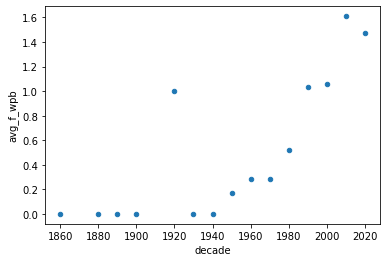

In [5]:
df_hard_analyzed.plot.scatter(x="decade", y="avg_f_wpb")

In [6]:
pearsonr(df_hard_analyzed['decade'], df_hard_analyzed['avg_m_wpb'])

(0.0758968303960085, 0.7880581062564699)

<AxesSubplot:xlabel='decade', ylabel='avg_m_wpb'>

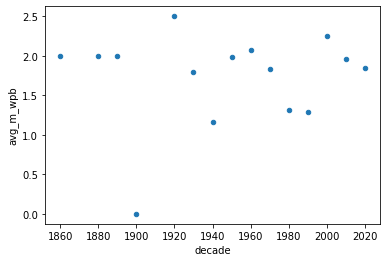

In [7]:
df_hard_analyzed.plot.scatter(x="decade", y="avg_m_wpb")

In [8]:
df_so = pd.read_csv('sf_space_opera.csv')
df_so.head()

,Book_Title,Original_Book_Title,Author_Name,Edition_Language,Rating_score,Rating_votes,Review_number,Book_Description,Year_published,Genres,url
0,Leviathan Wakes,Leviathan Wakes,James S.A. Corey,English,4.25,181488,12298,"Humanity has colonized the solar system—Mars, ...",2011,"{'Science Fiction': 5792, 'Fiction': 1950, 'Sp...",https://www.goodreads.com/book/show/8855321-le...
1,Ancillary Justice,Ancillary Justice,Ann Leckie,English,3.97,85505,8694,"On a remote, icy planet, the soldier known as ...",2013,"{'Science Fiction': 4088, 'Fiction': 1327, 'Sp...",https://www.goodreads.com/book/show/17333324-a...
2,Caliban's War,Caliban's War,James S.A. Corey,English,4.34,102557,5808,"We are not alone.On Ganymede, breadbasket of t...",2012,"{'Science Fiction': 3129, 'Fiction': 976, 'Spa...",https://www.goodreads.com/book/show/12591698-c...
3,"The Long Way to a Small, Angry Planet","The Long Way to a Small, Angry Planet",Becky Chambers,English,4.15,80639,12511,Follow a motley crew on an exciting journey th...,2014,"{'Science Fiction': 4289, 'Fiction': 1326, 'LG...",https://www.goodreads.com/book/show/22733729-t...
4,Dune,Dune,Frank Herbert,English,4.23,815463,26256,"Set on the desert planet Arrakis, Dune is the ...",1965,"{'Science Fiction': 13877, 'Fiction': 7372, 'F...",https://www.goodreads.com/book/show/44767458-dune


In [9]:
df_so_analyzed = text_analysis(df_so)
print(df_so_analyzed)

    decade  # books  she  her  female  woman  girl   he  his  male  man  boy  \
0     1910        2    1    3       0      1     0    2    3     0    0    0   
1     1920        1    0    0       0      0     0    0    5     0    0    0   
2     1930        4    0    0       0      0     0    0    3     0    0    0   
3     1940        3    0    0       0      0     0    2    3     0    1    1   
4     1950       21    2    0       0      1     1   20   21     0   10    1   
5     1960       25    2    2       1      1     0   38   31     0    7    2   
6     1970       32    5    6       0      2     0   35   37     0   11    0   
7     1980       76   19   22       0      3     2   53   82     0   10    1   
8     1990      178   96  189       1      9     4   83  141     0   22    2   
9     2000      278  141  285       3     14     4  215  336     2   54    4   
10    2010      597  457  919       2     34    24  445  588     0   78   14   
11    2020       33   30   98       0   

In [10]:
pearsonr(df_so_analyzed['decade'], df_so_analyzed['avg_f_wpb'])

(0.5720975557450176, 0.05193234037760485)

<AxesSubplot:xlabel='decade', ylabel='avg_f_wpb'>

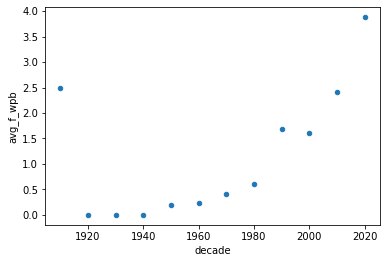

In [11]:
df_so_analyzed.plot.scatter(x="decade", y="avg_f_wpb")

In [18]:
pearsonr(df_so_analyzed['decade'], df_so_analyzed['avg_m_wpb'])

(-0.4823914953774874, 0.11221672663658865)

<AxesSubplot:xlabel='decade', ylabel='avg_m_wpb'>

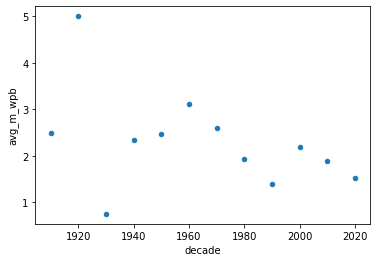

In [12]:
df_so_analyzed.plot.scatter(x="decade", y="avg_m_wpb")

In [13]:


# removes all punctuation
# https://stackoverflow.com/questions/1276764/stripping-everything-but-alphanumeric-chars-from-a-string-in-python
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z ]+', '', text)

# define words to count here

female_words = ['she', 'her', 'female', 'woman', 'girl']
male_words = ['he', 'his', 'male', 'man', 'boy']
words_of_interest = female_words + male_words

def text_analysis(df):
    # Create dictionary to keep counts of all rows per decade
    counts_per_decade =  dict()
    
    # go row by row
    # https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
    for index, row in df.iterrows():
        
        # 'row[column]' specifies the cell you are working with, like excel. 
        year = int(row['Year_published'])
        if year == 0: # filtering out missing years 
            continue
        if year == 1912: # filtering out outlier years 
            continue
        
        # Get book description cell as lower case string
        book_description = str(row['Book_Description']).lower()
        book_description = remove_punctuation(book_description) # calling the function to clean the text
        
        # Seperate description into a list of strings. split() always returns a list 
        words_in_book_description = book_description.split(' ')
        
        # Create a dictionary for counts of this row
        counts = {
            'number_of_books': 1, # number_of_books is always 1, count 1 per row
        }
        
        # For each word defined in words_of_interest, create a key in counts with value 0
        for word in words_of_interest:
            counts[word] = 0
        
        # For each word in book description that matches a word of interest, add 1 to its count in dictionary
        for word in words_in_book_description:
            if word in words_of_interest: 
                counts[word] += 1
        
        # Calculate decade by dividing by 10 and rounding down 
        # https://stackoverflow.com/questions/31481589/separating-list-of-years-into-decades
        decade = int(year/10) * 10
        
        # If counts_per_decade for this decade already had counts, add those old counts to new counts
        # counts_per_decade {1980: {he: 1, she: 2}}
        if decade in counts_per_decade:
            # for each old count, add it to counts
            for key, old_count in counts_per_decade[decade].items():
                counts[key] += old_count
        
        # At this point we have the latest counts for this decade
        # Set the new counts for this decade and continue with next row
        counts_per_decade[decade] = counts

    # At this point we are done with all books and have all the counts for all decades
    
    # Pandas needs the data in a specific format
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
    pandas_dict = {
        'decade': [], # each key will be a column in DataFrame
        '# books': [],
    }
    # Create one column per word in words_of_interest
    for word in words_of_interest:
        pandas_dict[word] = []
    
    # For each decade, enter counts to the pandas_dict. Each decade will be a row in DataFrame
    for decade, counts in sorted(counts_per_decade.items()): #sorted() sorts in ascending ordee the decades 
        pandas_dict['decade'].append(decade)
        pandas_dict['# books'].append(counts['number_of_books'])
        for word in words_of_interest:
            pandas_dict[word].append(counts[word])
    
    # At this point we have the full pandas_dict
    # Convert it to DataFrame https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html
    data_frame = pd.DataFrame.from_dict(pandas_dict)
    
    # Calculate more columns from existing columns using lambdas
    # https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
    def total_words(row, list_of_words):
        total_count = 0
        for word in list_of_words:
            total_count += row[word]
        return total_count
            
            
    def average_words_per_book(row, list_of_words):
        num_books = row['# books']
        total_count = total_words(row, list_of_words)
        return total_count / num_books
        
    # Lambda notation basically means this: data_frame.for_each_row(apply: average_words_per_book(row, words))
    data_frame['total_female_words'] = data_frame.apply (lambda row: total_words(row, female_words), axis=1)
    data_frame['total_male_words'] = data_frame.apply (lambda row: total_words(row, male_words), axis=1)
    
    data_frame['avg_f_wpb'] = data_frame.apply (lambda row: average_words_per_book(row, female_words), axis=1)
    data_frame['avg_m_wpb'] = data_frame.apply (lambda row: average_words_per_book(row, male_words), axis=1)
    
    return data_frame

df_so_analyzed = text_analysis(df_so)
print(df_so_analyzed)

    decade  # books  she  her  female  woman  girl   he  his  male  man  boy  \
0     1910        1    0    0       0      1     0    2    1     0    0    0   
1     1920        1    0    0       0      0     0    0    5     0    0    0   
2     1930        4    0    0       0      0     0    0    3     0    0    0   
3     1940        3    0    0       0      0     0    2    3     0    1    1   
4     1950       21    2    0       0      1     1   20   21     0   10    1   
5     1960       25    2    2       1      1     0   38   31     0    7    2   
6     1970       32    5    6       0      2     0   35   37     0   11    0   
7     1980       76   19   22       0      3     2   53   82     0   10    1   
8     1990      178   96  189       1      9     4   83  141     0   22    2   
9     2000      278  141  285       3     14     4  215  336     2   54    4   
10    2010      597  457  919       2     34    24  445  588     0   78   14   
11    2020       33   30   98       0   

In [14]:
pearsonr(df_so_analyzed['decade'], df_so_analyzed['avg_f_wpb'])

(0.78152469028655, 0.002680489538724783)

<AxesSubplot:xlabel='decade', ylabel='avg_f_wpb'>

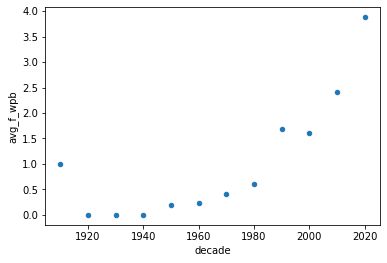

In [15]:
df_so_analyzed.plot.scatter(x="decade", y="avg_f_wpb")

In [16]:
pearsonr(df_so_analyzed['decade'], df_so_analyzed['avg_m_wpb'])

(-0.4823914953774874, 0.11221672663658865)

<AxesSubplot:xlabel='decade', ylabel='avg_m_wpb'>

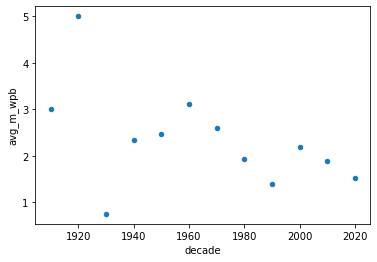

In [17]:
df_so_analyzed.plot.scatter(x="decade", y="avg_m_wpb")